In [1]:
import requests
import zipfile
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression


In [ ]:
# Download the file
url = "https://cs.stanford.edu/~minalee/zip/chi2022-coauthor-v1.0.zip"
response = requests.get(url)
zip_filename = "chi2022-coauthor-v1.0.zip"

with open(zip_filename, "wb") as file:
    file.write(response.content)

with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(".")

os.remove(zip_filename)

In [4]:
dataset_dir = './coauthor-v1.0'
paths = [
    os.path.join(dataset_dir, path)
    for path in os.listdir(dataset_dir)
    if path.endswith('jsonl')
]

print(f'Successfully downloaded {len(paths)} writing sessions in CoAuthor!')

Successfully downloaded 1447 writing sessions in CoAuthor!


In [5]:
import json

def read_writing_session(path):
    events = []
    with open(path, 'r') as f:
        for event in f:
            events.append(json.loads(event))
    #print(f'Successfully read {len(events)} events in a writing session from {path}')
    return events

In [6]:
events = read_writing_session(paths[0])

In [7]:
from datetime import datetime
def calculate_response_times(events):
    response_times = []
    suggestion_start_time = None

    for event in events:
        event_name = event['eventName']
        timestamp = event['eventTimestamp']
        
        # checking to make sure we handle the timestamp properly
        if isinstance(timestamp, int):
            timestamp = datetime.fromtimestamp(timestamp / 1000)
        elif isinstance(timestamp, str):
            timestamp = datetime.fromisoformat(timestamp)
        else:
            print(f"Invalid timestamp: {event}")
            continue
        
        # this means the user has asked for a suggestion
        if event_name == 'suggestion-get':
            suggestion_start_time = timestamp

        # we check for the next time (since suggestion-get) that the user selects or closes the suggestion.
        elif event_name in {'suggestion-select', 'suggestion-close'} and suggestion_start_time:
            response_time = (timestamp - suggestion_start_time).total_seconds()
            response_times.append(response_time)
            suggestion_start_time = None

    return response_times

In [8]:
def aggregate_response_times(paths):
    session_response_times = {}
    
    # loop through each file path that has the session data
    for i, path in enumerate(paths):
        events = read_writing_session(path)
        
        response_times = calculate_response_times(events)
        
        # add the response times for the session into a dictionary, keyed by the session number
        session_response_times[f'Session {i + 1}'] = response_times
        
    return session_response_times

In [9]:
session_response_times = aggregate_response_times(paths)

In [10]:
def plot_response_times_for_multiple_sessions(session_response_times, num_sessions=20):

    session_names = list(session_response_times.keys())[:num_sessions]
    
    plt.figure(figsize=(12, 8))
    
    # plotting all the response times
    for session_name in session_names:
        response_times = session_response_times[session_name]
        plt.plot(response_times, marker='o', label=session_name)
    
    plt.title(f'Response times for first {num_sessions} sessions')
    plt.xlabel('Suggestion position in sequence')
    plt.ylabel('Response time (s)')
    plt.legend(loc='upper right', fontsize='small', ncol=2)  
    plt.show()


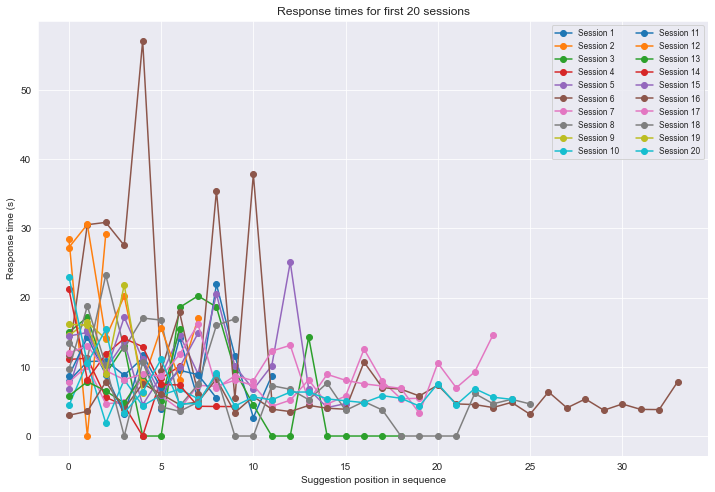

In [12]:
plot_response_times_for_multiple_sessions(session_response_times, num_sessions=20)

In [17]:
def plot_aggregated_response_times(session_response_times, window_size=5):
    max_length = max(len(times) for times in session_response_times.values())
    
    # aggregates response time by position across all sessions
    aggregated_times = [[] for _ in range(max_length)]
    for times in session_response_times.values():
        for i, time in enumerate(times):
            aggregated_times[i].append(time)
    
    # calculates average response time per position
    avg_response_times = [np.mean(times) if times else 0 for times in aggregated_times]
    
    # creates a rolling average (i've set the default window to be 5)
    rolling_avg = np.convolve(avg_response_times, np.ones(window_size) / window_size, mode='valid')
    
    plt.figure(figsize=(10, 6))
    plt.plot(rolling_avg, marker='o', color='blue', label='Rolling avg response time')
    plt.title(f'Rolling avg response time across all sessions')
    plt.xlabel('Suggestion position in sequence')
    plt.ylabel('Avg. response time (s)')
    plt.legend()
    plt.show()


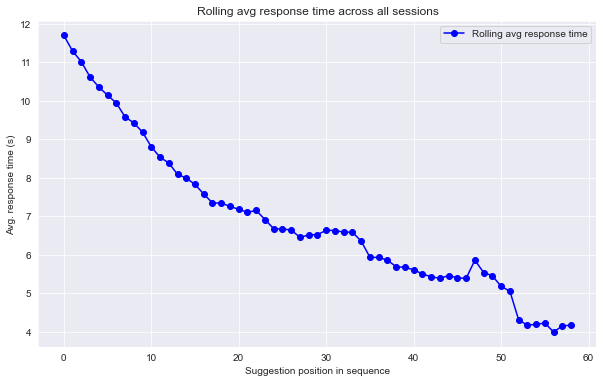

In [18]:
plot_aggregated_response_times(session_response_times, window_size=5)

In [19]:
from scipy.stats import ttest_ind

def early_late_split(session_response_times, split_ratio=0.5, outlier_threshold=30):
    early_segment_means = []
    late_segment_means = []
    
    for session_name, response_times in session_response_times.items():
        # i removed outlier response times (which we can adjust the threshold of if needed, default 30 seconds)
        filtered_times = [time for time in response_times if time <= outlier_threshold]
        
        if not filtered_times:
            continue
        
        n = len(filtered_times)
        split_point = int(n * split_ratio)  
        early_segment = filtered_times[:split_point]
        late_segment = filtered_times[split_point:]
        
        # calculating avg response times for each segment
        if early_segment:
            early_segment_means.append(np.mean(early_segment))
        if late_segment:
            late_segment_means.append(np.mean(late_segment))
    
    return early_segment_means, late_segment_means

early_means, late_means = early_late_split(
    session_response_times, split_ratio=0.5, outlier_threshold=30
)

# t-test
t_stat, p_value = ttest_ind(early_means, late_means, equal_var=False)
print(f"t-statistic: {t_stat}")
print(f"p-value: {p_value}")


t-statistic: 6.218090897257567
p-value: 5.799589873489121e-10


This suggests there is indeed a significant difference between the means of early and late response times (which we could see in the chart)

## Self-assessment survey analysis

In [20]:
file_path = 'CoAuthor - Metadata & Survey.xlsx' 
metadata_creative = pd.read_excel(file_path, sheet_name='Metadata (creative)')
survey_creative = pd.read_excel(file_path, sheet_name='Survey (creative)')
metadata_argumentative = pd.read_excel(file_path, sheet_name='Metadata (argumentative)')
survey_argumentative = pd.read_excel(file_path, sheet_name='Survery (argumentative)')

In [21]:
survey_creative.rename(columns={"Please enter verification code from this writing session (session_id)": "session_id"}, inplace=True)
survey_argumentative.rename(columns={"Please enter verification code from this writing session (session_id)": "session_id"}, inplace=True)

merged_creative = pd.merge(metadata_creative, survey_creative, on="session_id", how="inner")
merged_argumentative = pd.merge(metadata_argumentative, survey_argumentative, on="session_id", how="inner")

In [22]:
merged_creative.columns

Index(['timestamp', 'worker_id', 'session_id', 'prompt_code', 'temperature',
       'frequency_penalty', 'num_query', 'num_selected', 'perc_selected',
       'num_cursor', 'time', 'num_event', 'written_by_human', 'Timestamp',
       'Please enter your worker ID', 'Is English your first language?',
       'During this writing session, the suggestions you received were grammatically correct, and contributed to the fluency of the story.',
       'During this writing session, the suggestions helped me come up with new ideas.',
       'During this writing session, I felt like that I would have written a *better* story if I wrote the story alone.',
       'During this writing session, the system was competent (having expert knowledge and ability to perform a task successfully) in writing.',
       'During this writing session, the system was capable of writing creative stories.',
       'During this writing session, the system understood what I was trying to write.',
       'Which aspects of

In [23]:
# renaming the survey column name with the perceived contribution so it is easier to follow
for col in merged_creative.columns:
    if 'written by me' in col.lower():
        survey_column_creative = col
        merged_creative.rename(columns={survey_column_creative: 'perceived_written_by_human'}, inplace=True)
        break

for col in merged_argumentative.columns:
    if 'written by me' in col.lower():
        survey_column_argumentative = col
        merged_argumentative.rename(columns={survey_column_argumentative: 'perceived_written_by_human'}, inplace=True)
        break

# removing one outlier value (could also assume it means 90-100 and use 95, but dropping since only 1 value)
merged_argumentative = merged_argumentative[merged_argumentative['perceived_written_by_human'] != '90-10%']

creative_comparison = merged_creative[['written_by_human', 'perceived_written_by_human']]
argumentative_comparison = merged_argumentative[['written_by_human', 'perceived_written_by_human']]


In [24]:
creative_comparison

,written_by_human,perceived_written_by_human
0,30.0,50.0
1,86.0,80.0
2,66.0,90.0
3,79.0,75.0
4,91.0,85.0
...,...,...
740,56.0,75.0
741,55.0,65.0
742,82.0,80.0
743,79.0,75.0


In [25]:
merged_creative.columns

Index(['timestamp', 'worker_id', 'session_id', 'prompt_code', 'temperature',
       'frequency_penalty', 'num_query', 'num_selected', 'perc_selected',
       'num_cursor', 'time', 'num_event', 'written_by_human', 'Timestamp',
       'Please enter your worker ID', 'Is English your first language?',
       'During this writing session, the suggestions you received were grammatically correct, and contributed to the fluency of the story.',
       'During this writing session, the suggestions helped me come up with new ideas.',
       'During this writing session, I felt like that I would have written a *better* story if I wrote the story alone.',
       'During this writing session, the system was competent (having expert knowledge and ability to perform a task successfully) in writing.',
       'During this writing session, the system was capable of writing creative stories.',
       'During this writing session, the system understood what I was trying to write.',
       'Which aspects of

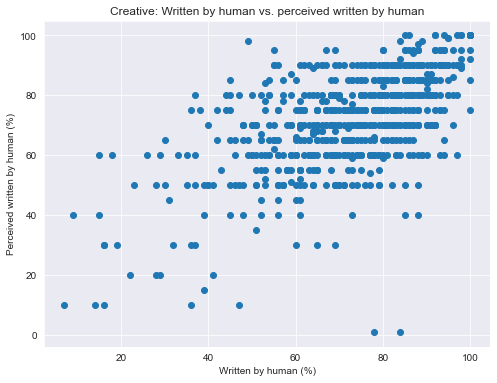

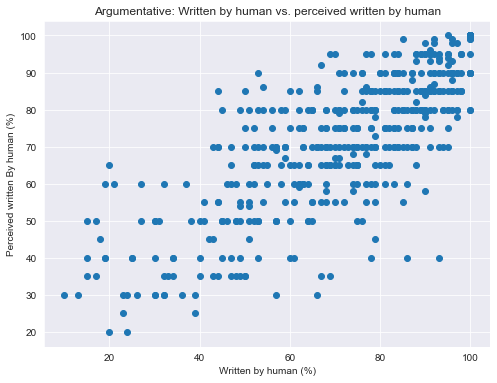

In [26]:
# plotting creative data
plt.figure(figsize=(8, 6))
plt.scatter(creative_comparison['written_by_human'], creative_comparison['perceived_written_by_human'])
plt.title('Creative: Written by human vs. perceived written by human')
plt.xlabel('Written by human (%)')
plt.ylabel('Perceived written by human (%)')
plt.show()

# plotting argumentative data
plt.figure(figsize=(8, 6))
plt.scatter(argumentative_comparison['written_by_human'], argumentative_comparison['perceived_written_by_human'])
plt.title('Argumentative: Written by human vs. perceived written by human')
plt.xlabel('Written by human (%)')
plt.ylabel('Perceived written By human (%)')
plt.show()

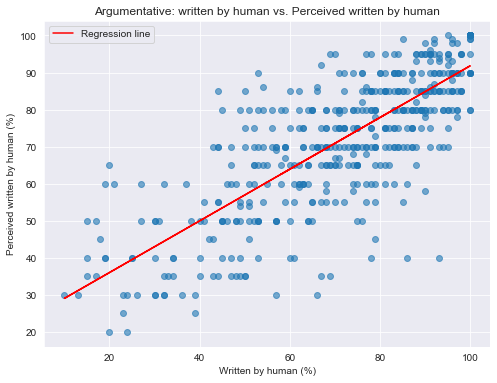

slope: 0.697236987647304, intercept: 22.0893981145364


In [27]:
X = argumentative_comparison['written_by_human'].values.reshape(-1, 1)
y = argumentative_comparison['perceived_written_by_human'].values

reg = LinearRegression().fit(X, y)
y_pred = reg.predict(X)

plt.figure(figsize=(8, 6))
plt.scatter(argumentative_comparison['written_by_human'], argumentative_comparison['perceived_written_by_human'], alpha=0.6)
plt.plot(argumentative_comparison['written_by_human'], y_pred, color='red', label=f'Regression line')
plt.title('Argumentative: written by human vs. Perceived written by human')
plt.xlabel('Written by human (%)')
plt.ylabel('Perceived written by human (%)')
plt.legend()
plt.savefig('visualizations/human_vs_perceived.png', dpi=300,bbox_inches='tight')
plt.show()

print(f"slope: {reg.coef_[0]}, intercept: {reg.intercept_}")


In [28]:
print(reg.score(X,y))


0.6248007074375851


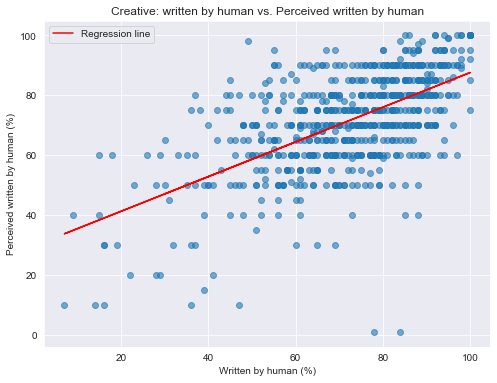

slope: 0.5796585930652255, intercept: 29.650662263397976


In [29]:
X = creative_comparison['written_by_human'].values.reshape(-1, 1)
y = creative_comparison['perceived_written_by_human'].values

reg = LinearRegression().fit(X, y)
y_pred = reg.predict(X)

plt.figure(figsize=(8, 6))
plt.scatter(creative_comparison['written_by_human'], creative_comparison['perceived_written_by_human'], alpha=0.6)
plt.plot(creative_comparison['written_by_human'], y_pred, color='red', label=f'Regression line')
plt.title('Creative: written by human vs. Perceived written by human')
plt.xlabel('Written by human (%)')
plt.ylabel('Perceived written by human (%)')
plt.legend()
plt.show()

print(f"slope: {reg.coef_[0]}, intercept: {reg.intercept_}")

In [30]:
print(reg.score(X,y))


0.3619409637019342


R^2 for the Creative prompts is significantly lower than the R^2 for Argumentative prompts